In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data_steven_anon.csv')

In [4]:
input_features = (['dem_pat_age_at_inclusion', 'dem_pat_gender', 'dem_pat_BMI'] 
                    + list(df.columns[df.columns.str.startswith('med_hist')].values)
                    + list(df.columns[df.columns.str.startswith('adm') & ~df.columns.isin(['adm_date', 'adm_dept', 'adm_hosp_date'])].values))

In [25]:
X = df[input_features]
y = df['COVID_and_prob_and_pos']

In [26]:
y.value_counts()

1    314
0    120
Name: COVID_and_prob_and_pos, dtype: int64

In [98]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from lightgbm.sklearn import LGBMClassifier
clf = LGBMClassifier(n_jobs=-1)
clf = BaggingClassifier(clf, n_estimators=500, bootstrap_features=True)
cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=7).mean()

Exception ignored in: <function Booster.__del__ at 0x0000016E02467678>
Traceback (most recent call last):
  File "c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\basic.py", line 2288, in __del__
    _safe_call(_LIB.LGBM_BoosterFree(self.handle))
OSError: exception: access violation writing 0x0000000000000000


0.6796875

In [43]:
X_train, y_train = X[df.institute_abbreviation == 'RUNMC'], y[df.institute_abbreviation == 'RUNMC']
X_test, y_test = X[df.institute_abbreviation != 'RUNMC'], y[df.institute_abbreviation != 'RUNMC']

In [51]:
clf = LGBMClassifier(n_jobs=-1)
clf = BaggingClassifier(clf, n_estimators=3000, bootstrap_features=True)
clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=LGBMClassifier(), bootstrap_features=True,
                  n_estimators=3000)

In [79]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.8821119356833642

In [84]:
import re
class PasswordFilter(object):
    def __init__(self, strings_to_filter, stream):
        self.stream = stream
        self.strings_to_filter = strings_to_filter

    def __getattr__(self, attr_name):
        return getattr(self.stream, attr_name)

    def write(self, data):
        if data.strip() == '' and '\n' in data:
            return
        for string in self.strings_to_filter:
            if string in data:
                return
        self.stream.write(data)
        self.stream.flush()

    def flush(self):
        self.stream.flush()

In [63]:
import sys
old_out = sys.stdout

In [85]:
filter_words = ['[LightGBM]']
sys.stdout = PasswordFilter(filter_words, old_out)

In [99]:
import lightgbm as lgb

import optuna
import numpy as np

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import warnings

# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf', 'goss']),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 100.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 100.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 400),
        'max_depth': trial.suggest_int('max_depth', 0, 40), 
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1.0),
        'feature_fraction_bynode': trial.suggest_uniform('feature_fraction_bynode', 0.01, 1.0), 
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 200),
        'linear_tree': trial.suggest_categorical('linear_tree', [False, True]), 
        'feature_pre_filter': False, 
        'max_bin': trial.suggest_int('max_bin', 7, 511), 
        'extra_trees': trial.suggest_categorical('extra_trees', [False, True]), 
        'path_smooth': trial.suggest_loguniform('path_smooth', 1e-12, 100), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-30, 1), 
        'min_gain_to_split': trial.suggest_loguniform('min_gain_to_split', 1e-20, 100), 
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-6, 1e2), 
        'num_boost_round': trial.suggest_int('num_boost_round', 2, 600)
    }
    
    if param['boosting_type'] != 'goss':
        not_goss_params = {
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 0.999999),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 100),
        }
        param.update(not_goss_params)

    if param['boosting_type'] == 'dart':
        dart_params = {
          'drop_rate': trial.suggest_uniform('drop_rate', 0.01, 1.0), 
          'max_drop': trial.suggest_int('max_drop', 0, 200), 
          'skip_drop': trial.suggest_uniform('skip_drop', 0.001, 1.0), 
          'xgboost_dart_mode': trial.suggest_categorical('xgboost_dart_mode', [False, True]), 
          'uniform_drop': trial.suggest_categorical('uniform_drop', [False, True])
        }

        param.update(dart_params)
    
    clf = LGBMClassifier(n_jobs=-1, **param)
#     clf = BaggingClassifier(LGBMClassifier(n_jobs=-1, **param), n_estimators=55, 
#                             bootstrap=trial.suggest_categorical('bootstrap', [False, True]), 
#                             bootstrap_features=trial.suggest_categorical('bootstrap_features', [False, True]), 
#                            max_samples=trial.suggest_uniform('max_samples', 0.01, 1.0), 
#                            max_features=trial.suggest_uniform('max_features', 0.01, 1.0))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return cross_val_score(clf, (X_train), y_train, cv=RepeatedStratifiedKFold(n_repeats=5), scoring='roc_auc').mean()
#     aucs = []
#     for i in range(5):
#         train_data = lgb.Dataset(imputer.transform(X_train), label=y_train)
#         aucs.append(lgb.cv(param, train_data, num_boost_round=num_boost_round, nfold=7)['auc-mean'][-1])
#     # auc = roc_auc_score(split_data(test)[1], bst.predict(split_data(test)[0]))
#     return np.mean(aucs)

In [60]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')

[I 2021-05-17 20:45:10,586] A new study created in memory with name: no-name-74bb4595-8822-457b-b076-a4722588b820


In [92]:
study.enqueue_trial({'boosting_type': 'gbdt',
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'max_depth': 0,
 'feature_fraction': 1,
 'feature_fraction_bynode': 1,
 'min_child_samples': 20,
 'linear_tree': False,
 'max_bin': 255,
 'extra_trees': False,
 'num_boost_round': 100, 
 'path_smooth': 0, 
 'bagging_fraction': 0.999999, 
 'bagging_freq': 99})

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\ipykernel_launcher.py:15: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  from ipykernel import kernelapp as app
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\optuna\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\optuna\study.py:857: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})


In [181]:
study.optimize(objective, n_trials=1000)

[I 2021-05-17 21:53:50,745] Trial 258 finished with value: 0.7440098814229249 and parameters: {'boosting_type': 'rf', 'lambda_l1': 5.120755697322511e-08, 'lambda_l2': 1.0651948732605134e-08, 'num_leaves': 378, 'max_depth': 27, 'feature_fraction': 0.8327870430943521, 'feature_fraction_bynode': 0.24685101199335172, 'min_child_samples': 2, 'linear_tree': False, 'max_bin': 120, 'extra_trees': True, 'path_smooth': 2.3588408540715134e-10, 'learning_rate': 2.5748967294104398e-26, 'min_gain_to_split': 2.4719026585779106e-18, 'min_sum_hessian_in_leaf': 0.0002489329259289947, 'num_boost_round': 559, 'bagging_fraction': 0.8898115064685196, 'bagging_freq': 79}. Best is trial 231 with value: 0.7646126482213438.
[I 2021-05-17 21:53:56,216] Trial 259 finished with value: 0.7444051383399208 and parameters: {'boosting_type': 'rf', 'lambda_l1': 1.9231214679087477e-08, 'lambda_l2': 3.925056283102334e-09, 'num_leaves': 359, 'max_depth': 31, 'feature_fraction': 0.8733243416387816, 'feature_fraction_bynode'

KeyboardInterrupt: 

In [436]:
df.COVID_diagnosis.value_counts()

1    235
0    120
2     46
3     33
Name: COVID_diagnosis, dtype: int64

In [182]:
best_params = study.best_params
best_params

{'boosting_type': 'rf',
 'lambda_l1': 6.884269737839954e-09,
 'lambda_l2': 4.0555182480057986e-09,
 'num_leaves': 372,
 'max_depth': 29,
 'feature_fraction': 0.8654247515226506,
 'feature_fraction_bynode': 0.333151994541971,
 'min_child_samples': 2,
 'linear_tree': False,
 'max_bin': 127,
 'extra_trees': True,
 'path_smooth': 9.014205697120713e-10,
 'learning_rate': 1.8796072914567394e-25,
 'min_gain_to_split': 3.171183632796391e-17,
 'min_sum_hessian_in_leaf': 0.000503616528793947,
 'num_boost_round': 541,
 'bagging_fraction': 0.9393130931839874,
 'bagging_freq': 82}

In [222]:
best_params['num_boost_round'] = 500

In [223]:
clf = LGBMClassifier(n_jobs=-1, **best_params)
# clf = BaggingClassifier(clf, n_estimators=1200, bootstrap_features=True)
clf.fit(X_train, y_train)

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.9393130931839874, bagging_freq=82,
               boosting_type='rf', extra_trees=True,
               feature_fraction=0.8654247515226506,
               feature_fraction_bynode=0.333151994541971,
               lambda_l1=6.884269737839954e-09,
               lambda_l2=4.0555182480057986e-09,
               learning_rate=1.8796072914567394e-25, linear_tree=False,
               max_bin=127, max_depth=29, min_child_samples=2,
               min_gain_to_split=3.171183632796391e-17,
               min_sum_hessian_in_leaf=0.000503616528793947,
               num_boost_round=500, num_leaves=372,
               path_smooth=9.014205697120713e-10)

In [143]:
from dagging import DaggingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
dag_clf = make_pipeline(
    SimpleImputer(strategy='mean'), 
    DaggingClassifier(n_estimators=30)
)
# imputer = SimpleImputer(strategy='mean').fit(X_train, y_train)
dag_clf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('daggingclassifier', DaggingClassifier(n_estimators=30))])

In [145]:
boost_clf = LGBMClassifier(n_jobs=-1)
boost_clf.fit(X_train, y_train)

LGBMClassifier()

In [196]:
np.random.choice([np.nan, np.nan, 3], size=5)

array([ 3.,  3.,  3., nan,  3.])

In [197]:
def column_impute(X):
    X = X.copy()
    for col in X.columns:
        X.loc[X[col].isna(), col] = np.random.choice(X[col].dropna(), size=X[col].isna().sum())
    return X

In [340]:
from sklearn.base import TransformerMixin
class ColumnImputer(TransformerMixin):
    def fit(self, X):
        self.options = {col: X[col].dropna().values for col in X.columns}
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            if len(self.options[col]) > 0:
                X.loc[X[col].isna(), col] = np.random.choice(self.options[col], size=X[col].isna().sum())
        return X

<AxesSubplot:>

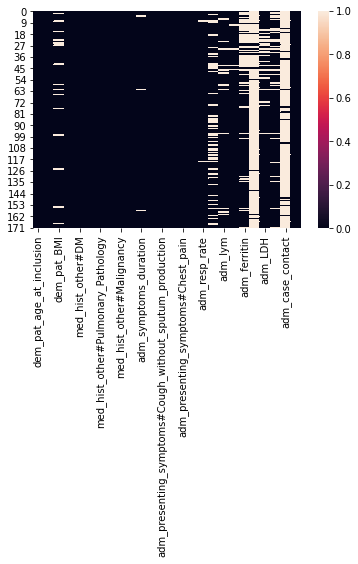

In [438]:
import seaborn as sns
sns.heatmap(X_train.isna())

In [209]:
from sklearn.preprocessing import FunctionTransformer, Binarizer
col_imputer = FunctionTransformer(column_impute, validate=False)
ColumnImputer().fit_transform(X_train).isna().any().any()

False

In [429]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
X_train_rep = []
y_train_rep = []
# col_imputer = ColumnImputer()
col_imputer = IterativeImputer(sample_posterior=True)
col_imputer.fit(X_train)
for i in tqdm(range(700)):
    X_train_rep.append(col_imputer.transform(X_train))
    y_train_rep.append(y_train)
    

In [430]:
# X_train_rep = pd.concat(X_train_rep)
y_train_rep = pd.concat(y_train_rep)
X_train_rep = np.concatenate(X_train_rep)

In [431]:
lgbm = LGBMClassifier(n_jobs=-1)
clf.fit(X_train_rep, y_train_rep)

Found `num_boost_round` in params. Will use it instead of argument


LGBMClassifier(bagging_fraction=0.9393130931839874, bagging_freq=82,
               boosting_type='rf', extra_trees=True,
               feature_fraction=0.8654247515226506,
               feature_fraction_bynode=0.333151994541971,
               lambda_l1=6.884269737839954e-09,
               lambda_l2=4.0555182480057986e-09,
               learning_rate=1.8796072914567394e-25, linear_tree=False,
               max_bin=127, max_depth=29, min_child_samples=2,
               min_gain_to_split=3.171183632796391e-17,
               min_sum_hessian_in_leaf=0.000503616528793947,
               num_boost_round=500, num_leaves=372,
               path_smooth=9.014205697120713e-10)

In [433]:
X_test_rep = []
y_test_rep = []
for i in tqdm(range(500)):
    X_test_rep.append(col_imputer.transform(X_test))
    y_test_rep.append(y_test)
# X_test_rep = pd.concat(X_test_rep)
y_test_rep = pd.concat(y_test_rep)
X_test_rep = np.concatenate(X_test_rep)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:51<00:00,  2.91it/s]


In [414]:
s = len(X_test)
roc_auc_score(y_test, np.array([clf.predict_proba(X_test_rep[s*i:s*(i+1)]) for i in range(500)]).mean(axis=0)[:, 1])

0.7980055658627088

In [417]:
roc_auc_score(y_test, clf.fit(X_train, y_train).predict_proba(X_test)[:, 1])

Found `num_boost_round` in params. Will use it instead of argument


0.9066171923314781

In [418]:
roc_auc_score(y_test, lgbm.fit(X_train, y_train).predict_proba(X_test)[:, 1])

0.8576066790352505

In [425]:
from tqdm import tqdm
def get_shapley_values(est, X, n):
    explainer = shap.TreeExplainer(est)
    s = len(X)//n
    shaps = []
    for i in tqdm(range(n)):
        shaps.append(explainer.shap_values(X[s*i:s*(i+1)])[1])
    
    return np.mean(shaps, axis=0)

In [426]:
shaps_col_impute = get_shapley_values(clf, X_test_rep, 500)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:37<00:00,  5.12it/s]


In [434]:
shaps_mice_impute = get_shapley_values(clf, X_test_rep, 500)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [13:01<00:00,  1.56s/it]


In [427]:
shaps_normal = get_shapley_values(clf.fit(X_train, y_train), X_test, 1)

Found `num_boost_round` in params. Will use it instead of argument
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


In [375]:
df_ictcf = pd.read_pickle('../../data/processed/ictcf.pkl')

In [376]:

for col in df_ictcf.select_dtypes(include=['category']):
    if col not in ['Metadata_PCR', 'Metadata_Hospital']:
        df_ictcf[col] = df_ictcf[col].cat.codes.astype('category')
        df_ictcf.loc[df_ictcf[col] == -1, col] = np.nan

In [377]:
categorical_features = ["Metadata_Sex"] + [col for col in df_ictcf.columns if col.startswith("Disease_")]
numeric_features = [col for col in df_ictcf.columns if col.startswith("Value_")] + ['Metadata_Age',
                                                                              'Metadata_Temperature']
input_features = categorical_features + numeric_features
output_feature = "Metadata_PCR"

In [378]:
X_ictcf_train, y_ictcf_train = df_ictcf.loc[df_ictcf.Metadata_Hospital == 'Union', input_features], df_ictcf.loc[df_ictcf.Metadata_Hospital == 'Union', output_feature]
X_ictcf_test, y_ictcf_test = df_ictcf.loc[df_ictcf.Metadata_Hospital != 'Union', input_features], df_ictcf.loc[df_ictcf.Metadata_Hospital != 'Union', output_feature]

In [341]:
from sklearn.preprocessing import FunctionTransformer, Binarizer
col_imputer = FunctionTransformer(column_impute, validate=False)
ColumnImputer().fit_transform(X_ictcf_train).isna().any().any()

True

In [383]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from tqdm import tqdm
X_train_rep = []
y_train_rep = []
# col_imputer = ColumnImputer()
col_imputer = IterativeImputer(sample_posterior=True, n_nearest_features=20)
col_imputer.fit(X_ictcf_train)
for i in tqdm(range(100)):
    X_train_rep.append(col_imputer.transform(X_ictcf_train))
    y_train_rep.append(y_ictcf_train)
    

In [384]:
# X_train_rep = pd.concat(X_train_rep)
y_train_rep = pd.concat(y_train_rep)
X_train_rep = np.concatenate(X_train_rep)

In [406]:
lgbm = LGBMClassifier(n_jobs=-1)
clf.fit(X_train_rep, y_train_rep)

Found `num_boost_round` in params. Will use it instead of argument


LGBMClassifier(bagging_fraction=0.9393130931839874, bagging_freq=82,
               boosting_type='rf', extra_trees=True,
               feature_fraction=0.8654247515226506,
               feature_fraction_bynode=0.333151994541971,
               lambda_l1=6.884269737839954e-09,
               lambda_l2=4.0555182480057986e-09,
               learning_rate=1.8796072914567394e-25, linear_tree=False,
               max_bin=127, max_depth=29, min_child_samples=2,
               min_gain_to_split=3.171183632796391e-17,
               min_sum_hessian_in_leaf=0.000503616528793947,
               num_boost_round=500, num_leaves=372,
               path_smooth=9.014205697120713e-10)

In [391]:
X_test_rep = []
y_test_rep = []
for i in tqdm(range(20)):
    X_test_rep.append(col_imputer.transform(X_ictcf_test))
    y_test_rep.append(y_ictcf_test)
    

In [392]:
# X_test_rep = pd.concat(X_test_rep)
y_test_rep = pd.concat(y_test_rep)
X_test_rep = np.concatenate(X_test_rep)

In [396]:
X_test_rep[s*0:s*(0+1)]

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.75000000e+00,  6.60000000e+01,  4.07000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.38333333e-01,  6.10000000e+01,  3.75000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.96666667e-01,  5.80000000e+01,  3.48486015e+01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.50208258e-01,  3.40000000e+01,  4.03046195e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         2.28593329e-02,  5.70000000e+01,  3.80000000e+01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -1.19108646e+00,  6.60000000e+01,  3.85000000e+01]])

In [407]:
s = len(X_ictcf_test)
roc_auc_score(y_ictcf_test, np.array([clf.predict_proba(X_test_rep[s*i:s*(i+1)]) for i in range(20)]).mean(axis=0)[:, 1])

0.6510521170962597

In [403]:
roc_auc_score(y_ictcf_test, lgbm.fit(X_ictcf_train, y_ictcf_train).predict_proba(X_ictcf_test)[:, 1])

0.6507562895508565

In [404]:
import shap
explainer = shap.TreeExplainer(clf)

In [408]:
shaps = []
for i in range(20):
    shaps.append(explainer.shap_values(X_test_rep[s*i:s*(i+1)])[1])

LightGBMError: The number of features in data (89) is not the same as it was in training data (126).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
np.abs(X_test.isna() * np.mean(shaps, axis=0)).mean().mean()

In [318]:
np.abs(X_test.isna() * np.mean(shaps, axis=0)).mean().mean()

0.4592230238895519

In [316]:
np.abs(X_test.isna() * shaps[0]).mean().mean()

0.9719143428255106

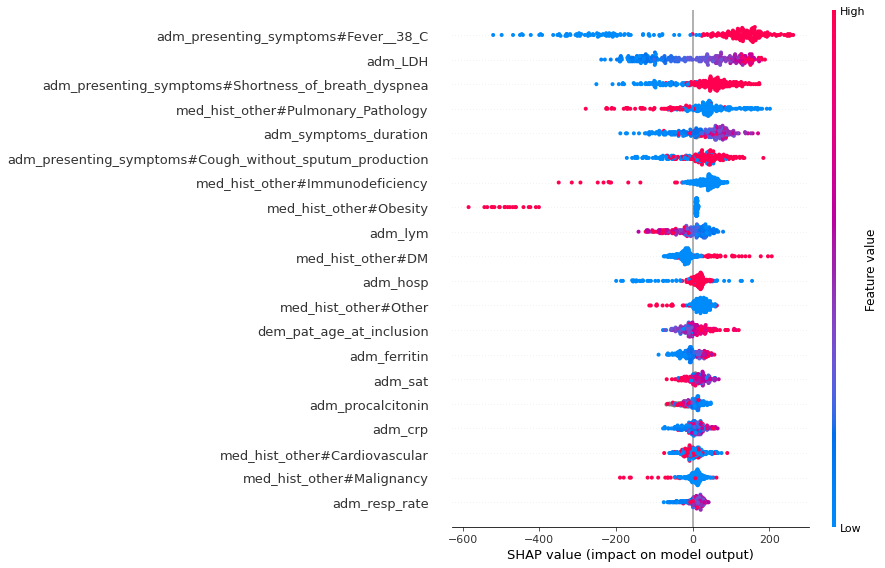

In [311]:
shap.summary_plot(np.mean(shaps, axis=0), features=X_test)

In [261]:
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


0.9066171923314781

In [253]:
from sklearn.impute import MissingIndicator
mi = MissingIndicator()
clf.fit(mi.fit_transform(X_train), y_train)
roc_auc_score(y_test, clf.predict_proba(mi.transform(X_test))[:, 1])

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


0.5793521954236239

In [169]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
vc = StackingClassifier([
    ('rf', clf), 
    ('dagg', dag_clf), 
    ('boost', boost_clf)
], cv=40)
vc.fit(X_train, y_train)

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument"

StackingClassifier(cv=40,
                   estimators=[('rf',
                                LGBMClassifier(bagging_fraction=0.969969446918676,
                                               bagging_freq=98,
                                               boosting_type='rf',
                                               extra_trees=True,
                                               feature_fraction=0.8603858595972851,
                                               feature_fraction_bynode=0.29441259701829886,
                                               lambda_l1=2.5131739589822892e-08,
                                               lambda_l2=2.752166594463962e-07,
                                               learning_rate=2.9524541694763445e-26,
                                               linear_tree=False, max_bin=164,
                                               max_depth=29,
                                               min_child_samples=2,
                           

In [186]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.9021335807050094

In [9]:
pd.Series(df.columns).head(60)

0                                             record_id
1                                institute_abbreviation
2                              dem_pat_age_at_inclusion
3                                        dem_pat_gender
4                                           dem_pat_BMI
5                         med_hist_other#Cardiovascular
6                                     med_hist_other#DM
7                                med_hist_other#Obesity
8                    med_hist_other#Pulmonary_Pathology
9                       med_hist_other#Immunodeficiency
10                            med_hist_other#Malignancy
11                                 med_hist_other#Other
12                                             adm_date
13                                             adm_dept
14                                adm_symptoms_duration
15                  adm_presenting_symptoms#Fever__38_C
16    adm_presenting_symptoms#Cough_without_sputum_p...
17    adm_presenting_symptoms#Shortness_of_breat

In [5]:
df.iloc[:, 2:]

,record_id,institute_abbreviation,dem_pat_age_at_inclusion,dem_pat_gender,dem_pat_BMI,med_hist_other#Cardiovascular,med_hist_other#DM,med_hist_other#Obesity,med_hist_other#Pulmonary_Pathology,med_hist_other#Immunodeficiency,...,f2_CT_CORADS_expert,f2_CT_pattern,f2_CT_severity_score,f2_CT_comorbidities_other,f2_lym,f2_crp,f2_ferritin,f2_ddimer,f2_LDH,f2_procalcitonin
0,10057,RUNMC,73,1,22.7,1,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10059,RUNMC,82,1,26.6,1,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10063,RUNMC,73,1,NaN,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10061,RUNMC,47,1,25.4,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10062,RUNMC,82,1,29.4,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,CWZ-CORADS-258,CWZ,65,2,NaN,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,CWZ-CORADS-259,CWZ,68,1,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,CWZ-CORADS-260,CWZ,75,2,NaN,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,CWZ-CORADS-261,CWZ,51,1,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
